# Introduccion

Rusty Bargain, empresa dedicada a la venta de carros usados, se encuentra desarrollando una app para atraer nuevos clientes, lo que hace atractiva la app es que pueda averiguar rápidamente el valor de mercado del coche del cliente. 

# Recursos

La compañia proporciona la siguiente información:

     - especificaciones técnicas
     - versiones de equipamiento
     - precios

# Objetivo

Crar un modelo que determine el valor de mercado de los vehiculos de los clientes. El modelo debe complir con los siguientes requerimientos:

    - la calidad de la predicción
    - la velocidad de la predicción
    - el tiempo requerido para el entrenamiento

## Preparación de datos

Importación de librerias

In [1]:
import pandas as pd 
import numpy as np
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as ltb 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline

from catboost import CatBoostRegressor, Pool
from time import time


In [2]:
df  = pd.read_csv("/datasets/car_data.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
display(df) 

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,21/03/2016 09:50,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,21/03/2016 00:00,0,2694,21/03/2016 10:42
354365,14/03/2016 17:48,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,14/03/2016 00:00,0,39576,06/04/2016 00:46
354366,05/03/2016 19:56,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,05/03/2016 00:00,0,26135,11/03/2016 18:17
354367,19/03/2016 18:57,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,19/03/2016 00:00,0,87439,07/04/2016 07:15


In [5]:
df.isnull().sum() # cuantos nulos hay?

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [6]:
print(f'El número total de filas duplicadas en este archivo es de {df.duplicated().sum()} filas.')

El número total de filas duplicadas en este archivo es de 262 filas.


In [7]:
duplicates = df[df.duplicated()]
print(duplicates)

             DateCrawled  Price  VehicleType  RegistrationYear Gearbox  Power  \
14266   21/03/2016 19:06   5999        small              2009  manual     80   
27568   23/03/2016 10:38  12200          bus              2011  manual    125   
31599   03/04/2016 20:41   4950        wagon              2003    auto    170   
33138   07/03/2016 20:45  10900  convertible              2005    auto    163   
43656   13/03/2016 20:48   4200        sedan              2003  manual    105   
...                  ...    ...          ...               ...     ...    ...   
349709  03/04/2016 20:52    700        small              1999  manual     60   
351555  26/03/2016 16:54   3150          bus              2003  manual     86   
352384  15/03/2016 21:54   5900        wagon              2006  manual    129   
353057  05/03/2016 14:16   9500        small              2013  manual    105   
353727  20/03/2016 17:56      1          NaN              2000     NaN      0   

           Model  Mileage  

In [8]:
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


### Descripción de los datos

El dataset proporcionado  cuenta con un total de registros de 354,369 y 16 columnas, de las cuales tenemos la siguiente información:

| Nombre de columna | Característica | Tipo de dato | Datos Nulos |
|-------------------|----------------|--------------|-------------|
| DateCrawled | Fecha en la que se descargó el perfil de la base de datos | object | 0 |
| Price | Precio | int64 | 0 |
| VehicleType | Tipo de carrocería del vehículo | object | 37,490 |
| RegistrationYear | Año de matriculación del vehículo | int64 | 0 |
| Gearbox | Tipo de caja de cambios | object | 19,833 |
| Power | Potencia (CV) | int64 | 0 |
| Model | Modelo del vehículo | object | 19,705 |
| Mileage | Kilometraje (medido en km de acuerdo con las especificidades regionales del conjunto de datos) | int64 | 0 |
| RegistrationMonth | Mes de matriculación del vehículo | int64 | 0 |
| FuelType | Tipo de combustible | object | 32,895 |
| Brand | Marca del vehículo | object | 0 |
| NotRepaired | Vehículo con o sin reparación | object | 71,154 |
| DateCreated | Fecha de creación del perfil | object | 0 |
| NumberOfPictures | Número de fotos del vehículo | int64 | 0 |
| PostalCode | Código postal del propietario del perfil (usuario) | int64 | 0 |
| LastSeen | Fecha de la última vez que el usuario estuvo activo | object | 0 |

Las columnas con fechas serán cambiados su tipo de datos: 

    - Solo se dejará año
        DateCrawled
        DateCreated
        LastSeen


Se tiene este total de valores asentes:

    VehicleType          37490 object 10.58%
    Gearbox              19833 object 5.6%
    Model                19705 object 5.6%
    FuelType             32895 object 9.28%
    NotRepaired          71154 object 20.08%

Los primeros 4 tipos de datos se pueden intentar llenar con kNN vecinos.
NotRepaired se rellanará con datos NaN.

Se observa que las columnas 'Price', 'Power' y tienen celdas con valores en 0, lo que podría ser anormal.

Los datos en la columna 'RegistrationYear' tiene un rango de años estraño que va del 1000 al 9999.
Se desconoce la razón por la cual la columna 'NumberOfPictures' presenta sus datos en 0.

El número total de filas duplicadas en este archivo es de 262 filas, mismas que se procederan a eliminarse, debido a que son muy pocos registro, que hay duplicados en filas que incluyen fecha y hora exacta y que no se puede investigar la razón de su probable duplicidad.

In [9]:
df = df.drop_duplicates()

In [10]:
print(f'El número total de filas duplicadas en este archivo es de {df.duplicated().sum()} filas.')

El número total de filas duplicadas en este archivo es de 0 filas.


Cambio de nombre de las columnas a snake case!

In [11]:
def to_snake_case(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

In [12]:
df.columns = [to_snake_case(col) for col in df.columns]

In [13]:
display(df)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,21/03/2016 09:50,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,21/03/2016 00:00,0,2694,21/03/2016 10:42
354365,14/03/2016 17:48,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,14/03/2016 00:00,0,39576,06/04/2016 00:46
354366,05/03/2016 19:56,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,05/03/2016 00:00,0,26135,11/03/2016 18:17
354367,19/03/2016 18:57,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,19/03/2016 00:00,0,87439,07/04/2016 07:15


Cambio de tipo de dato a las columnas con fecha

In [14]:
columns_date = ['date_crawled', 'date_created', 'last_seen']

In [15]:
for columns in columns_date:
    df[columns] = pd.to_datetime(df[columns], infer_datetime_format=True)

In [16]:
for columns in columns_date:
    df[columns] = pd.DatetimeIndex(df[columns]).year 

display(df)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016,0,70435,2016
1,2016,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016,0,66954,2016
2,2016,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016,0,90480,2016
3,2016,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016,0,91074,2016
4,2016,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016,0,60437,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016,0,2694,2016
354365,2016,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016,0,39576,2016
354366,2016,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016,0,26135,2016
354367,2016,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016,0,87439,2016


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354107 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354107 non-null  int64 
 1   price               354107 non-null  int64 
 2   vehicle_type        316623 non-null  object
 3   registration_year   354107 non-null  int64 
 4   gearbox             334277 non-null  object
 5   power               354107 non-null  int64 
 6   model               334406 non-null  object
 7   mileage             354107 non-null  int64 
 8   registration_month  354107 non-null  int64 
 9   fuel_type           321218 non-null  object
 10  brand               354107 non-null  object
 11  not_repaired        282962 non-null  object
 12  date_created        354107 non-null  int64 
 13  number_of_pictures  354107 non-null  int64 
 14  postal_code         354107 non-null  int64 
 15  last_seen           354107 non-null  int64 
dtypes:

Ya con los datos duplicados eliminados, y las fechas ya adaptadas se procede a revisar lo antes indicado.

Se revisa profundamente las columnas 'Price', 'Power'y  'RegistrationYear'

In [18]:
df.loc[:,['price', 'power', 'registration_year']].describe()

,price,power,registration_year
count,354107.000000,354107.000000,354107.000000
mean,4416.433287,110.089651,2004.235355
std,4514.338584,189.914972,90.261168
min,0.000000,0.000000,1000.000000
25%,1050.000000,69.000000,1999.000000
50%,2700.000000,105.000000,2003.000000
75%,6400.000000,143.000000,2008.000000
max,20000.000000,20000.000000,9999.000000


In [19]:
columns_interest = ['price', 'power', 'registration_year']

for col in columns_interest:
    print('\n',col)
    print(df[col].sort_values().unique())


 price
[    0     1     2 ... 19998 19999 20000]

 power
[    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    22    23
    24    25    26    27    28    29    30    31    32    33    34    35
    36    37    38    39    40    41    42    43    44    45    46    47
    48    49    50    51    52    53    54    55    56    57    58    59
    60    61    62    63    64    65    66    67    68    69    70    71
    72    73    74    75    76    77    78    79    80    81    82    83
    84    85    86    87    88    89    90    91    92    93    94    95
    96    97    98    99   100   101   102   103   104   105   106   107
   108   109   110   111   112   113   114   115   116   117   118   119
   120   121   122   123   124   125   126   127   128   129   130   131
   132   133   134   135   136   137   138   139   140   141   142   143
   144   145   146   147   148   149   150   151   152   153   154

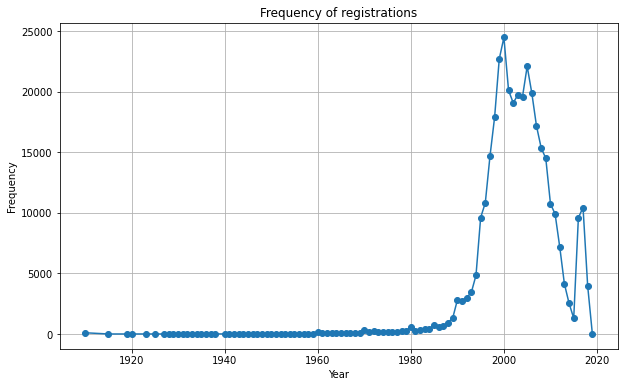

In [20]:
df_filtered_year = df[(df['registration_year'] >= 1900) & (df['registration_year'] <= 2020)]

value_frequency = df_filtered_year['registration_year'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.plot(value_frequency.index, value_frequency.values, marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Frequency of registrations')
plt.grid(True)
plt.show()

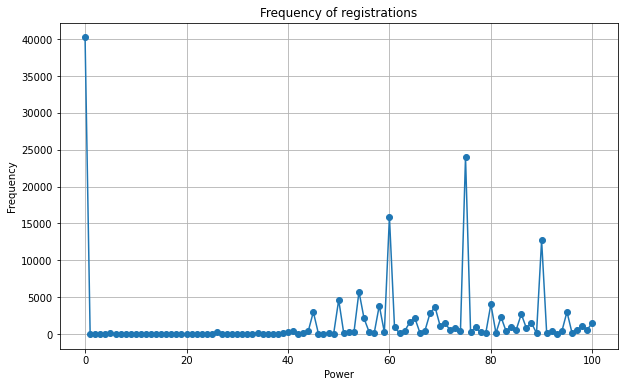

In [21]:
df_filtered_power = df[(df['power'] >= 0) & (df['power'] <= 100)]

value_frequency_2 = df_filtered_power['power'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.plot(value_frequency_2.index, value_frequency_2.values, marker='o', linestyle='-')
plt.xlabel('Power')
plt.ylabel('Frequency')
plt.title('Frequency of registrations')
plt.grid(True)
plt.show()

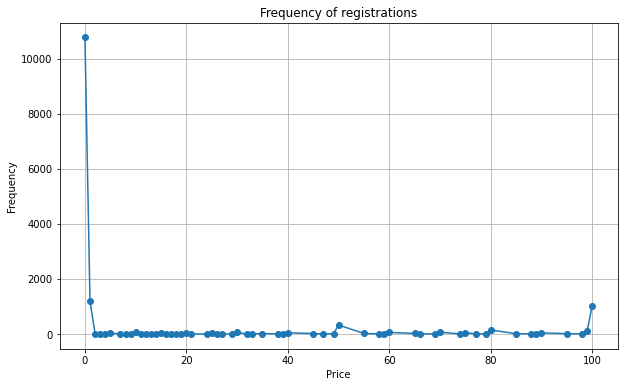

In [22]:
df_filtered_price = df[(df['price'] >= 0) & (df['price'] <= 100)]

value_frequency_3 = df_filtered_price['price'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.plot(value_frequency_3.index, value_frequency_3.values, marker='o', linestyle='-')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Frequency of registrations')
plt.grid(True)
plt.show()

Se decide observar el comportamiento de los datos para considerar los datos que se conservarán.

        Para años que van de 1900 a 2020
        Para Power a partir de 40
        Para Price a partir de 50

In [23]:
df = df.loc[(df['registration_year'] >= 1900) & (df['registration_year'] <= 2020)]
df = df.loc[(df['power'] >= 40) & (df['price'] >= 50)]

In [24]:
df = df.reset_index(drop=True)

In [25]:
display(df)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016,0,66954,2016
1,2016,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016,0,90480,2016
2,2016,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016,0,91074,2016
3,2016,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016,0,60437,2016
4,2016,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016,0,33775,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304786,2016,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no,2016,0,51371,2016
304787,2016,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes,2016,0,96465,2016
304788,2016,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016,0,26135,2016
304789,2016,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016,0,87439,2016


In [26]:
df[df['vehicle_type'].isna()].head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
13,2016,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016,0,38871,2016
19,2016,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016,0,49716,2016
23,2016,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016,0,31139,2016
28,2016,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016,0,37075,2016
31,2016,350,NaN,2016,manual,75,golf,150000,4,petrol,volkswagen,no,2016,0,19386,2016


Se trabaja un moda condicionada para las siguientes columnas con datos ausentes:

    vehicle_type   
    gearbox              
    model                
    fuel_type     
    
La columna 'NotRepaired' no se trabajará, debido a que no es una característica que se pueda obtener por medio de una moda condicionada.

Para trabajar la moda condicionada se toman las siguientes columnas:

    registration_year
    power   
    brand 
    
Y se crean nuevas columnas para alojar esa moda y ocuparle después para rellenar en la columnas originales los datos faltantes.

In [27]:
conditional_mode_vehicle_type = df.groupby(['registration_year', 'power', 'brand'])['vehicle_type'] \
         .transform(lambda x: x.astype(str).mode(dropna=False).iloc[0])
df['vehicle_type'] = df['vehicle_type'].fillna(conditional_mode_vehicle_type)

conditional_mode_gearbox = df.groupby(['registration_year', 'power', 'brand'])['gearbox'] \
         .transform(lambda x: x.astype(str).mode(dropna=False).iloc[0])
df['gearbox'] = df['gearbox'].fillna(conditional_mode_gearbox)

conditional_mode_model = df.groupby(['registration_year', 'power', 'brand'])['model'] \
         .transform(lambda x: x.astype(str).mode(dropna=False).iloc[0])
df['model'] = df['model'].fillna(conditional_mode_model)

conditional_mode_fuel_type = df.groupby(['registration_year', 'power', 'brand'])['fuel_type'] \
         .transform(lambda x: x.astype(str).mode(dropna=False).iloc[0])
df['fuel_type'] = df['fuel_type'].fillna(conditional_mode_fuel_type)

El tratamiento de la columna 'not_repaired' que indica si un vehículo ha sido reparado o no, al tener valores ausentes y no poder determinarlos por una media condicionada, se determina que a los datos ausentes serán colocados como un 'no'.         

In [28]:
df['not_repaired'] = df['not_repaired'].fillna('no')

In [29]:
df.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
mileage               0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

Por último, para determinar con qué columnas trabajar, se revisa la correlación de las variables

In [30]:
df.corr()

,date_crawled,price,registration_year,power,mileage,registration_month,date_created,number_of_pictures,postal_code,last_seen
date_crawled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,NaN,1.000000,0.433249,0.135768,-0.390009,0.071027,-0.004458,NaN,0.063994,NaN
registration_year,NaN,0.433249,1.000000,0.024966,-0.276936,0.024070,-0.000764,NaN,0.019195,NaN
power,NaN,0.135768,0.024966,1.000000,0.020280,0.009692,0.000095,NaN,0.010583,NaN
mileage,NaN,-0.390009,-0.276936,0.020280,1.000000,-0.017449,0.004791,NaN,-0.011883,NaN
registration_month,NaN,0.071027,0.024070,0.009692,-0.017449,1.000000,0.003010,NaN,0.002809,NaN
date_created,NaN,-0.004458,-0.000764,0.000095,0.004791,0.003010,1.000000,NaN,0.002138,NaN
number_of_pictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
postal_code,NaN,0.063994,0.019195,0.010583,-0.011883,0.002809,0.002138,NaN,1.000000,NaN
last_seen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


La matriz de correlación muestra que no hay relación entre el precio y las columnas: 'date_crawled', 'registration_month', 'date_created', 'number_of_pictures', 'postal_code' y 'last_seen'.

Por lo cual se dejarán fuera de los modelos. Por lo que la información con la que se trabajará será el siguiente:

Columna objetivo

    price - precio al que se vende el vehículo

Columnas características

    vehicle_type - tipo de carrocería del vehículo
    registration_year - año de matriculación del vehículo
    gearbox - tipo de caja de cambios
    power - potencia (CV)
    model - modelo
    mileage - kilometraje (Km)
    fuel_type - tipo de combustible
    brand - marca del vehículo
    not_repaired - vehículo con o sin reparación

## Entrenamiento del modelo 

Se entrena diferentes modelos con varios hiperparámetros con el objetivo de comparar la métrica raíz del error cuadrático medio (RECM).

Se ejecutarán las siguientes modelos:

    - Modelo de regresión lineal (como prueba de cordura)
    - Modelo árbol de decision
    - Modelo bosque aleatorio
    - LightGBM

### Separación y división de datos

70% entrenamiento
30% validación

In [42]:
nan_rows = df[df.apply(lambda row: row.astype(str).str.contains('nan').any(), axis=1)]

# Mostrar las filas que contienen "nan"
print("Filas que contienen 'nan':")
print(nan_rows)

Filas que contienen 'nan':
        date_crawled  price vehicle_type  registration_year gearbox  power  \
13              2016    300          nan               2016  manual     60   
19              2016   2900          nan               2018  manual     90   
23              2016   5555          nan               2017  manual    125   
28              2016    899          nan               2016  manual     60   
31              2016    350          nan               2016  manual     75   
...              ...    ...          ...                ...     ...    ...   
304723          2016   5000          nan               2017  manual    120   
304752          2016   9400        wagon               2007  manual    200   
304758          2016   2999        wagon               2004  manual    234   
304766          2016   3850  convertible               2006  manual    108   
304786          2016   5250          nan               2016    auto    150   

          model  mileage  registrati

In [31]:
target = df['price']
features = df.drop(['date_crawled', 'price', 'registration_month', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'], axis=1)


features_train, features_valid, target_train, target_valid = train_test_split(features, target, 
                                                                              test_size=0.3, random_state=12345 )

In [37]:
target

0         18300
1          9800
2          1500
3          3600
4           650
          ...  
304786     5250
304787     3200
304788     1199
304789     9200
304790     3400
Name: price, Length: 304791, dtype: int64

In [38]:
features

,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
0,coupe,2011,manual,190,a6,125000,gasoline,audi,yes
1,suv,2004,auto,163,grand,125000,gasoline,jeep,no
2,small,2001,manual,75,golf,150000,petrol,volkswagen,no
3,small,2008,manual,69,fabia,90000,gasoline,skoda,no
4,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...
304786,nan,2016,auto,150,159,150000,nan,alfa_romeo,no
304787,sedan,2004,manual,225,leon,150000,petrol,seat,yes
304788,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
304789,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Se hace uso de la codificación One-Hot (OHE) para transformar características categóricas a carácteristicas numéricas.

In [32]:
features_ohe = pd.get_dummies(features,drop_first=True) 

features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(features_ohe, target,
                                                                              test_size=0.3, random_state=12345 )

In [33]:
features_ohe

,registration_year,power,mileage,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_nan,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_yes
0,2011,190,125000,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2004,163,125000,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2001,75,150000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,2008,69,90000,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,1995,102,150000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304786,2016,150,150000,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
304787,2004,225,150000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
304788,2000,101,125000,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
304789,1996,102,150000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [34]:
features_train_ohe

,registration_year,power,mileage,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_nan,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_yes
181151,2009,120,60000,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
760,2010,102,70000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
101292,1990,90,150000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
281792,2007,92,70000,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
151299,1996,98,150000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158838,2004,177,150000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
47873,1999,125,150000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
86398,1995,116,150000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
77285,1999,150,150000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


# Aquí quería meter StandardScaler pero  fue cuando me di cuenta que mi dataset tenia 'nan'

### Creación de función

Se implementa una función para calcular tiempo de entrenamiento y tiempo para hacer predicciones.

In [ ]:
def train_and_pred_time(model, features_train, target_train, features_valid):
    start_time1 = time()
    train = model.fit(features_train, target_train)
    end_time1 = time()
    train_time = end_time1 - start_time1
    
    start_time2 = time()
    predictions = model.predict(features_valid)
    end_time2 = time()
    pred_time = end_time2 - start_time2
    
    return train_time, pred_time, predictions


### Modelos

Regresión lineal

In [ ]:
model_lr = LinearRegression() 

lr_train_time, lr_pred_time, lr_pred = train_and_pred_time(model_lr, features_train_ohe, target_train_ohe, features_valid_ohe)

In [ ]:
lr_train_rmse = round(mean_squared_error(target_train_ohe, model_lr.predict(features_train_ohe)),2)
lr_valid_rmse = round(mean_squared_error(target_valid_ohe,lr_pred),2)

print(f'RMSE training set: {lr_train_rmse}') 
print(f'RMSE validation set: {lr_valid_rmse}')
print(f'Training Time: {lr_train_time}')
print(f'Prediction Time: {lr_pred_time}')

Regresión lineal con DGE

In [ ]:
model_lrg = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-3, random_state=12345))

lrg_train_time, lrg_pred_time, lrg_predictions = train_and_pred_time(model_lrg, features_train_ohe, target_train_ohe, features_valid_ohe)

lrg_train_rmse = round(mean_squared_error(target_train_ohe, model_lrg.predict(features_train_ohe)), 2)
lrg_valid_rmse = round(mean_squared_error(target_valid_ohe, lrg_predictions), 2)

# Imprimir los resultados
print(f'RMSE training set: {lrg_train_rmse}') 
print(f'RMSE validation set: {lrg_valid_rmse}')
print(f'Training Time: {lrg_train_time}')
print(f'Prediction Time: {lrg_pred_time}')

Arból de desición

In [ ]:
param_grid = {'max_depth': [1,2,4,6,8,10,15,20]}

tree_reg = DecisionTreeRegressor(random_state=12345)
grid_search = GridSearchCV(estimator=tree_reg, param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(features_train_ohe, target_train_ohe)

final_model = grid_search.best_estimator_
final_model

# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter

- [x]  Jupyter Notebook está abierto
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en orden de ejecución
- [x]  Los datos han sido descargados y preparados
- [x]  Los modelos han sido entrenados
- [x]  Se realizó el análisis de velocidad y calidad de los modelos